<a href="https://colab.research.google.com/github.com/Fra-Sala/gnn_time/blob/main/notebook/11_lid_cavity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

>>check bottleneck nodes and map nodes

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
# Clone and/or import gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/Fra-Sala/gnn_time.git
    sys.path.append('gca_time')
else:
    sys.path.append('./..')
    
from gca_time import network, pde, loader, plotting, preprocessing, training, initialization, testing, error, gui


In [4]:
import numpy as np
from itertools import product

# Define PDE problem

In [5]:
problem_name, variable, mu_space,n_param = pde.problem(12)
params = mu_space[0]
time = mu_space[1]
print("\nProblem: ", problem_name)
print("Variable: ", variable)
print("Simulations: ", n_param)
argv = gui.hyperparameters_selection(problem_name, variable, n_param)

# Training rate
argv[5] = 70  # 70% of the data is used for training

HyperParams = network.HyperParams(argv)


Problem:  lid_cavity
Variable:  VX_VY
Simulations:  20


# Initialize device and set reproducibility

In [6]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)
initialization.set_path(HyperParams)

Device used:  cpu


# Load dataset

In [7]:
if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gca_time/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'
       
dataset = loader.LoadDataset(dataset_dir, variable, dim_velocity=2)
def delete_initial_condition(dataset, dim=2):
    if dim == 1:
        dataset.U = np.delete(dataset.U, np.s_[::10], 1)
    elif dim == 2:
        dataset.VX = np.delete(dataset.VX, np.s_[::10], 1)
        dataset.VY = np.delete(dataset.VY, np.s_[::10], 1)
    else:
        print("Invalid dimension. Please enter 1 or 2.")
    return dataset

dataset = delete_initial_condition(dataset, dim=2)

# Shrink dataset (debugging)

In [8]:
num_sim2keep = 3 # not greater than 20, in total (train and test, before application of train_rate)
num_snap2keep = 3 # # not greater than 9

def shrink_dataset(dataset, params, time, num_sim, num_snap_per_sim, dim=2):
    new_time = time[:num_snap_per_sim+1]
    new_params = params[:num_sim]
    
    if dim == 1:
        new_U = []
        new_XX = []
        new_YY = []
        for i in range(num_sim):
            start = i * (len(time) - 1)
            end = start + num_snap_per_sim
            new_U.append(dataset.U[:, start:end])
            new_XX.append(dataset.xx[:, start:end])
            new_YY.append(dataset.yy[:, start:end])
        new_U = np.concatenate(new_U, axis=1)
        new_XX = np.concatenate(new_XX, axis=1)
        new_YY = np.concatenate(new_YY, axis=1)

        return new_U, new_XX, new_time, new_params
    elif dim == 2:
        new_VX = []
        new_VY = []
        new_XX = []
        new_YY = []
        for i in range(num_sim):
            start = i * (len(time) - 1)
            end = start + num_snap_per_sim
            new_VX.append(dataset.VX[:, start:end])
            new_VY.append(dataset.VY[:, start:end])
            new_XX.append(dataset.xx[:, start:end])
            new_YY.append(dataset.yy[:, start:end])
        new_VX = np.concatenate(new_VX, axis=1)
        new_VY = np.concatenate(new_VY, axis=1)
        new_XX = np.concatenate(new_XX, axis=1)
        new_YY = np.concatenate(new_YY, axis=1)
    
        return torch.tensor(new_VX), torch.tensor(new_VY), torch.tensor(new_XX), torch.tensor(new_YY), new_time, new_params

dataset.VX, dataset.VY, dataset.xx, dataset.yy, time, params = shrink_dataset(dataset, params, time, num_sim2keep, num_snap2keep, dim=2)


time = torch.from_numpy(time)

print("Number of simulations (series of snaps):", len(params))
print("Number of instants of time (initial time excluded):", len(time)-1)

Number of simulations (series of snaps): 3
Number of instants of time (initial time excluded): 3


In [9]:

graph_loader, train_loader, test_loader, \
    val_loader, scaler_all, scaler_test, xyz, VAR_all, VAR_test, \
        train_trajectories, test_trajectories, params_train, params_test = preprocessing.graphs_dataset(dataset, HyperParams, params)



Number of nodes processed:  15681
Number of graphs processed:  9
Length of train dataset:  6
Length of test dataset:  3


# Define the architecture

In [10]:
model_decoder = network.Net(HyperParams)
model_dyn = network.DynNet(HyperParams)
model_decoder = model_decoder.to(device)
model_dyn = model_dyn.to(device)
torch.set_default_dtype(torch.float32)
torch.set_default_dtype(torch.float32)
optimizer = torch.optim.Adam([
    {'params': model_dyn.parameters()},
    {'params': model_decoder.parameters()}
], lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)

# Train or load a pre-trained network

In [11]:
try:
    model_decoder.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'_decoder.pt', map_location=torch.device('cpu')))
    model_dyn.load_state_dict(torch.load(HyperParams.net_dir+HyperParams.net_name+HyperParams.net_run+'_dyn.pt', map_location=torch.device('cpu')))
    print('Loading saved network')
except FileNotFoundError:
    print('Training network')
    training.train(model_decoder, model_dyn, optimizer, device, scheduler, train_loader, test_loader, HyperParams, params_train, params_test, time)
plotting.plot_loss(HyperParams)

Training network


  0%|          | 1/200 [00:52<2:53:06, 52.19s/it, Loss(training)=1.07, Loss(validation)=0.812]

# Evaluate the model

In [ ]:
model_decoder.to("cpu")
model_dyn.to("cpu")
#params = params.to("cpu")
#vars = "GCA-ROM"
results, latents = testing.evaluate(VAR_all, model_decoder, model_dyn, graph_loader, params, time, HyperParams)

Evaluating the model...
Evaluation complete!


# Plot the results

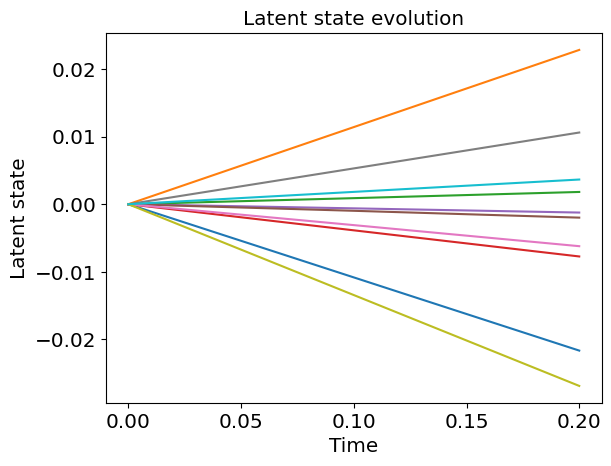

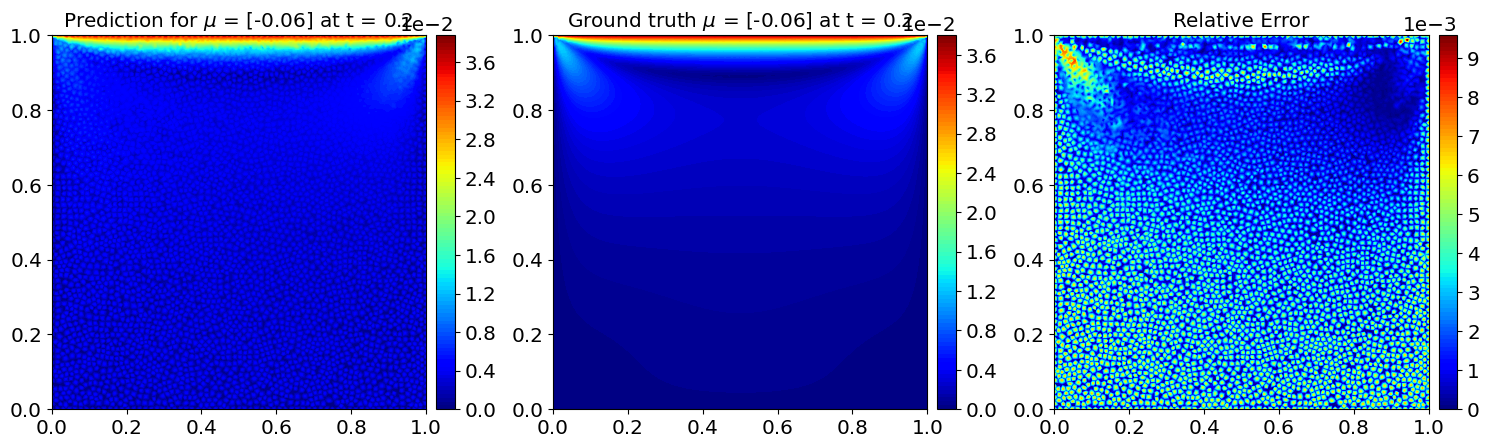

In [ ]:

snapshots = train_trajectories
PARAMS = np.repeat(params, len(time)-1, axis=0)
TIMES = np.tile(time[1:], params.shape[0])
time.detach().numpy()
for SNAP in snapshots:
    plotting.plot_latent(SNAP, latents, params, time, HyperParams)
    plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, PARAMS, TIMES)
# plotting.plot_error_multip(results, VAR_all, scaler_all, HyperParams, mu_space, params, train_trajectories, vars)

# #N = 10
# snapshots = test_trajectories[:10]
# #np.random.shuffle(snapshots)
# for SNAP in snapshots:
#     plotting.plot_fields(SNAP, results, scaler_all, HyperParams, dataset, xyz, params)
#     plotting.plot_error_fields(SNAP, results, VAR_all, scaler_all, HyperParams, dataset, xyz, params)

# results_test, _, _ = testing.evaluate(VAR_test, model, val_loader, params, HyperParams, test_trajectories)

In [ ]:
params.shape

(2, 1)

# Print the errors on the testing set

In [ ]:
# error_abs, norm = error.compute_error(results_test, VAR_test, scaler_test, HyperParams)
# error.print_error(error_abs, norm, vars)
# error.save_error(error_abs, norm, HyperParams, vars)

In [ ]:
#!zip -r /content/lid_cavity.zip /content/lid_cavity